# Training Model to Detect Zebrafish (96 well plate)

## 1. Introduction

#### This notebook goes over how to train a new model to detect zebrafish in 96 well plate system

This notebook illustrates how to :

1. import different modules
1. Read images
1. Detect wells
1. Crop wells to video for model generation using DeepLabCut
1. Create a DeepLabCut project
1. Extract frames
1. Label Frames
1. Create training dataset
1. Train network
1. Evaluate network
1. Analyze a novel video
1. Create an automatically labeled video
1. Plot the trajectories
1. Identify outlier frames
1. Annotate the outlier frames manually
1. Merge the data sets and update the training set
1. Train a network
1. Export trained model

The process can be summarized using the following figure

![Workflow](Workflow.png)

## 2. Preprocessing

In this section you will learn how to preprocess your images to videos, which can be utilized by DeepLabCut

In [2]:
# Include the directory where Data and Analysis modules are located

import sys
sys.path.append('../src')

import os

You are working with 2 modules here

1. **read_data** - used to load images
2. **analysis** - used to detect wells, crop different wells and create videos to be fed to DeepLabCut

In [3]:
# Load read_data and analysis modules

from read_data import Data
from analysis import analysis
%matplotlib inline

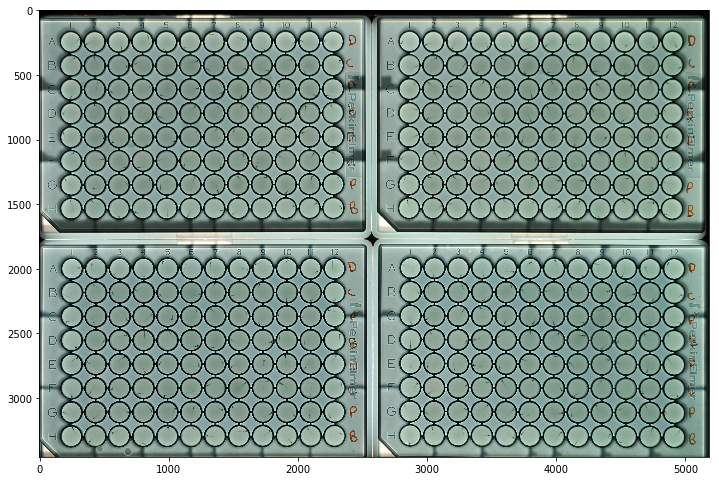

In [4]:
# Load images and the experiment

image_folder = # Specify where your images are located
images = Data(image_folder + 'IMG_%04d.JPG')
experiment = analysis(images)

# Check if the images loaded properly

ret, image = images.read(plot = True)
images.reset()

384

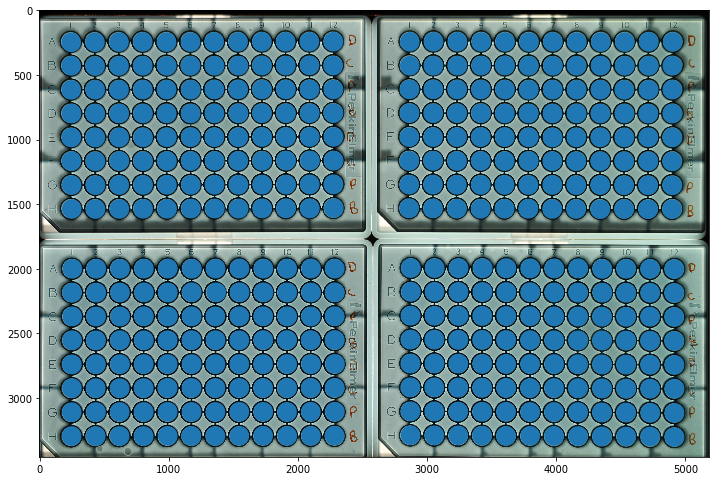

In [5]:
# Detect wells

# You need to provide 2 values for R = [rmin, rmax]
# Where rmin = minimum radius you expect for the well
#       rmax = maximum values you expect for the well
# If the radius of the well falls between rmin and rmax i.e. rmin < R < rmax then wells will be detected properly

wells = experiment.detect_wells(R = [72, 100])

# Once the wells are detected plot and see if all the wells have been detected
experiment.plot_wells(wells)
len(wells) # This function will print total number of wells detected

In [9]:
# Once the wells have been detected, crop the wells to videos to be used by DeepLabCut


%%time
cropped_dir = # Directory where videos are to be saved
!mkdir -p {cropped_dir}

filenames = experiment.crop_to_video(wells, crop_dir=cropped_dir, no_wells_to_record = 6)

Saving cropped images in /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped/ as a videos
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Wrote 6 videos to /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped/
CPU times: user 4min 37s, sys: 25.6 s, total: 5min 3s
Wall time: 5min 32s


## 3. Train Model using DeepLabCut

In this section you will learn how to train a new model provided a video

In [6]:
import deeplabcut
from datetime import datetime as dt
from deeplabcut.utils.auxiliaryfunctions import edit_config, attempttomakefolder

cropped_dir = # Directory where videos were saved

def get_list_of_videos(cropped_dir):
    import glob
    
    try:
        return glob.glob(cropped_dir + '*.avi')
    except Exception as e:
        print(e)

filenames = get_list_of_videos(cropped_dir)

project_dir = # Location where you want your project to be saved
project_name = # Name of the project
experimenter = # Name of the experimenter

attempttomakefolder(project_dir)

first_time = True # Change this to False incase you have already created a project before that you want to utilize

# You shouldn't have to change any of the code in this section
# ----------------------------------------------------------------------------------------------------------
if (first_time):
    deeplabcut.create_new_project(project_name,
                                  experimenter,
                                  filenames,
                                  working_directory=project_dir,
                                  copy_videos=False)
    
    date = dt.today().strftime("%Y-%m-%d")
    final_path = os.path.join(project_dir, 
                              '{pn}-{exp}-{date}'.format(pn = project_name, exp = experimenter, date=date))
    new_path = os.path.join(project_dir, 
                              '{pn}-{exp}'.format(pn = project_name, exp = experimenter))
    !mv {final_path} {new_path}
    path_to_config = os.path.join(new_path, 'config.yaml')
else:
    path_to_config = os.path.join(project_dir, '{pn}-{exp}'.format(pn = project_name, exp = experimenter),
                                  'config.yaml')
# ----------------------------------------------------------------------------------------------------------


## Change the variables as needed
bodyparts = ['right_eye', 'left_eye', 'yolk'] # change this if you need additional bodyparts
total_number_of_frames = 100 # Total number of frames to analyze

if (first_time):
    edits = ({  'project_path': new_path,
                'bodyparts' : ['right_eye', 'left_eye', 'yolk'],
                'numframes2pick':int(40/len(filenames)),
                'skeleton':[]})
    edit_config(path_to_config, edits)
    


Created "/gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/data/96_well_plate/DLC_project/Example_96_well_plates-Rohit-2020-11-06/videos"
Created "/gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/data/96_well_plate/DLC_project/Example_96_well_plates-Rohit-2020-11-06/labeled-data"
Created "/gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/data/96_well_plate/DLC_project/Example_96_well_plates-Rohit-2020-11-06/training-datasets"
Created "/gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/data/96_well_plate/DLC_project/Example_96_well_plates-Rohit-2020-11-06/dlc-models"
Attempting to create a symbolic link of the video ...
Created the symlink of /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped/16_15.avi to /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/data/96_well_plate/DLC_project/Example_96_well_plates-Rohit-2020-11-06/videos/16_15.avi
Created 

In [7]:
# You don't need to change anything here
# Once you run this cell - a new dialogue box will open up for you to label images

deeplabcut.extract_frames(path_to_config, mode='automatic', algo = 'kmeans', userfeedback=False)
deeplabcut.label_frames(path_to_config)

442it [00:00, 4418.66it/s]

Config file read successfully.
Extracting frames based on kmeans ...
Kmeans-quantization based extracting of frames from 0.0  seconds to 1805.0  seconds.
Extracting and downsampling... 1805  frames from the video.


1805it [00:00, 5361.79it/s]


Kmeans clustering ... (this might take a while)


659it [00:00, 6582.10it/s]

Extracting frames based on kmeans ...
Kmeans-quantization based extracting of frames from 0.0  seconds to 1805.0  seconds.
Extracting and downsampling... 1805  frames from the video.


1805it [00:00, 6399.42it/s]


Kmeans clustering ... (this might take a while)


619it [00:00, 6186.63it/s]

Extracting frames based on kmeans ...
Kmeans-quantization based extracting of frames from 0.0  seconds to 1805.0  seconds.
Extracting and downsampling... 1805  frames from the video.


1805it [00:00, 6293.80it/s]
/users/rkakodka/.local/lib/python3.7/site-packages/deeplabcut/generate_training_dataset/frame_extraction.py:248: UserWarning: /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/DLC_project/Example_96_well_plates-Rohit/labeled-data/11_01/img1801.png is a low contrast image
  io.imsave(img_name, image)


Kmeans clustering ... (this might take a while)


485it [00:00, 4848.89it/s]

Extracting frames based on kmeans ...
Kmeans-quantization based extracting of frames from 0.0  seconds to 1805.0  seconds.
Extracting and downsampling... 1805  frames from the video.


1805it [00:00, 5165.52it/s]
/users/rkakodka/.local/lib/python3.7/site-packages/deeplabcut/generate_training_dataset/frame_extraction.py:248: UserWarning: /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/DLC_project/Example_96_well_plates-Rohit/labeled-data/16_15/img1801.png is a low contrast image
  io.imsave(img_name, image)


Kmeans clustering ... (this might take a while)


469it [00:00, 4685.09it/s]

Extracting frames based on kmeans ...
Kmeans-quantization based extracting of frames from 0.0  seconds to 1805.0  seconds.
Extracting and downsampling... 1805  frames from the video.


1805it [00:00, 5491.45it/s]


Kmeans clustering ... (this might take a while)


496it [00:00, 4923.00it/s]

Extracting frames based on kmeans ...
Kmeans-quantization based extracting of frames from 0.0  seconds to 1805.0  seconds.
Extracting and downsampling... 1805  frames from the video.


1805it [00:00, 5520.90it/s]
/users/rkakodka/.local/lib/python3.7/site-packages/deeplabcut/generate_training_dataset/frame_extraction.py:248: UserWarning: /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/DLC_project/Example_96_well_plates-Rohit/labeled-data/22_03/img1803.png is a low contrast image
  io.imsave(img_name, image)


Kmeans clustering ... (this might take a while)
Frames were successfully extracted.

You can now label the frames using the function 'label_frames' (if you extracted enough frames for all videos).
You can now check the labels, using 'check_labels' before proceeding. Then, you can use the function 'create_training_dataset' to create the training dataset.


In [8]:
# Don't need to change anything here

deeplabcut.create_training_dataset(path_to_config, augmenter_type='imgaug')


The training dataset is successfully created. Use the function 'train_network' to start training. Happy training!


[(0.95,
  1,
  (array([21, 27, 13,  0,  7, 35, 18,  9, 28, 15, 11,  3, 34, 32,  1, 22, 19,
          16, 26,  2,  5, 12,  8, 20, 10, 17, 30, 33,  4,  6, 25, 14, 24, 31]),
   array([23, 29])))]

In [9]:
# Train your model
# To get decent accuracy for model - train the model for atleast 200,000 iterations

deeplabcut.train_network(path_to_config)

Config:
{'all_joints': [[0], [1], [2]],
 'all_joints_names': ['right_eye', 'left_eye', 'yolk'],
 'batch_size': 1,
 'bottomheight': 400,
 'crop': True,
 'crop_pad': 0,
 'cropratio': 0.4,
 'dataset': 'training-datasets/iteration-0/UnaugmentedDataSet_Example_96_well_platesNov6/Example_96_well_plates_Rohit95shuffle1.mat',
 'dataset_type': 'imgaug',
 'deterministic': False,
 'display_iters': 1000,
 'fg_fraction': 0.25,
 'global_scale': 0.8,
 'init_weights': '/users/rkakodka/.local/lib/python3.7/site-packages/deeplabcut/pose_estimation_tensorflow/models/pretrained/resnet_v1_50.ckpt',
 'intermediate_supervision': False,
 'intermediate_supervision_layer': 12,
 'leftwidth': 400,
 'location_refinement': True,
 'locref_huber_loss': True,
 'locref_loss_weight': 0.05,
 'locref_stdev': 7.2801,
 'log_dir': 'log',
 'max_input_size': 1500,
 'mean_pixel': [123.68, 116.779, 103.939],
 'metadataset': 'training-datasets/iteration-0/UnaugmentedDataSet_Example_96_well_platesNov6/Documentation_data-Example_96

Starting with imgaug pose-dataset loader.
Batch Size is 1
Initializing ResNet
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading ImageNet-pretrained resnet_50
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /users/rkakodka/.local/lib/python3.7/site-packages/deeplabcut/pose_estimation_tensorflow/models/pretrained/resnet_v1_50.ckpt
Training parameter:
{'stride': 8.0, 'weigh_part_predictions': False, 'weigh_negatives': False, 'fg_fraction': 0.25, 'weigh_only_present_joints': False, 'mean_pixel': [123.68, 116.779, 103.939], 'shuffle': True, 'snapshot_prefix': '/gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/DLC_project/Example_96_well_plates-Rohit/dlc-models/iteration-0/Example_96_well_platesNov6-trainset95shuffle1/train/snapshot', 'log_dir': 'log', 'global_scale': 0.8, 'location_refin

iteration: 1000 loss: 0.0517 lr: 0.005
iteration: 2000 loss: 0.0272 lr: 0.005
iteration: 3000 loss: 0.0214 lr: 0.005
iteration: 4000 loss: 0.0205 lr: 0.005
iteration: 5000 loss: 0.0182 lr: 0.005
iteration: 6000 loss: 0.0173 lr: 0.005
iteration: 7000 loss: 0.0159 lr: 0.005
iteration: 8000 loss: 0.0146 lr: 0.005
iteration: 9000 loss: 0.0139 lr: 0.005
iteration: 10000 loss: 0.0133 lr: 0.005
iteration: 11000 loss: 0.0292 lr: 0.02
iteration: 12000 loss: 0.0216 lr: 0.02
iteration: 13000 loss: 0.0191 lr: 0.02
iteration: 14000 loss: 0.0179 lr: 0.02
iteration: 15000 loss: 0.0164 lr: 0.02
iteration: 16000 loss: 0.0148 lr: 0.02
iteration: 17000 loss: 0.0147 lr: 0.02
iteration: 18000 loss: 0.0146 lr: 0.02
iteration: 19000 loss: 0.0138 lr: 0.02
iteration: 20000 loss: 0.0131 lr: 0.02
iteration: 21000 loss: 0.0126 lr: 0.02
iteration: 22000 loss: 0.0117 lr: 0.02
iteration: 23000 loss: 0.0120 lr: 0.02
iteration: 24000 loss: 0.0116 lr: 0.02
iteration: 25000 loss: 0.0119 lr: 0.02
iteration: 26000 loss: 0

KeyboardInterrupt: 

In [10]:
# Evaluate your network
# Once you run this step - labelled images will be created and stored in evaluated results

deeplabcut.evaluate_network(path_to_config, plotting=True)

Config:
{'all_joints': [[0], [1], [2]],
 'all_joints_names': ['right_eye', 'left_eye', 'yolk'],
 'batch_size': 1,
 'bottomheight': 400,
 'crop': True,
 'crop_pad': 0,
 'cropratio': 0.4,
 'dataset': 'training-datasets/iteration-0/UnaugmentedDataSet_Example_96_well_platesNov6/Example_96_well_plates_Rohit95shuffle1.mat',
 'dataset_type': 'imgaug',
 'deconvolutionstride': 2,
 'deterministic': False,
 'display_iters': 1000,
 'fg_fraction': 0.25,
 'global_scale': 0.8,
 'init_weights': '/users/rkakodka/.local/lib/python3.7/site-packages/deeplabcut/pose_estimation_tensorflow/models/pretrained/resnet_v1_50.ckpt',
 'intermediate_supervision': False,
 'intermediate_supervision_layer': 12,
 'leftwidth': 400,
 'location_refinement': True,
 'locref_huber_loss': True,
 'locref_loss_weight': 0.05,
 'locref_stdev': 7.2801,
 'log_dir': 'log',
 'max_input_size': 1500,
 'mean_pixel': [123.68, 116.779, 103.939],
 'metadataset': 'training-datasets/iteration-0/UnaugmentedDataSet_Example_96_well_platesNov6/Do

Running  DLC_resnet50_Example_96_well_platesNov6shuffle1_50000  with # of trainingiterations: 50000
Initializing ResNet
INFO:tensorflow:Restoring parameters from /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/DLC_project/Example_96_well_plates-Rohit/dlc-models/iteration-0/Example_96_well_platesNov6-trainset95shuffle1/train/snapshot-50000


0it [00:00, ?it/s]

Analyzing data...


36it [00:00, 46.54it/s]


Done and results stored for snapshot:  snapshot-50000
Results for 50000  training iterations: 95 1 train error: 1.5 pixels. Test error: 3.09  pixels.
With pcutoff of 0.6  train error: 1.5 pixels. Test error: 3.09 pixels
Thereby, the errors are given by the average distances between the labels by DLC and the scorer.
Plotting...


100%|██████████| 36/36 [00:15<00:00,  2.31it/s]

The network is evaluated and the results are stored in the subdirectory 'evaluation_results'.
If it generalizes well, choose the best model for prediction and update the config file with the appropriate index for the 'snapshotindex'.
Use the function 'analyze_video' to make predictions on new videos.
Otherwise consider retraining the network (see DeepLabCut workflow Fig 2)


In [12]:
# Crop a new video to test the model

filenames = experiment.crop_to_video(wells, crop_dir=cropped_dir, no_wells_to_record = 1)

Saving cropped images in /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped/ as a videos
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Wrote 1 videos to /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped/


In [13]:
# Analyze the new video
# A new labelled video is created - Please visually inspect to find out if the model is accurate

deeplabcut.analyze_videos(path_to_config, filenames, save_as_csv=True)
deeplabcut.create_labeled_video(path_to_config, filenames,save_frames=True)

Config:
{'all_joints': [[0], [1], [2]],
 'all_joints_names': ['right_eye', 'left_eye', 'yolk'],
 'batch_size': 1,
 'bottomheight': 400,
 'crop': True,
 'crop_pad': 0,
 'cropratio': 0.4,
 'dataset': 'training-datasets/iteration-0/UnaugmentedDataSet_Example_96_well_platesNov6/Example_96_well_plates_Rohit95shuffle1.mat',
 'dataset_type': 'imgaug',
 'deconvolutionstride': 2,
 'deterministic': False,
 'display_iters': 1000,
 'fg_fraction': 0.25,
 'global_scale': 0.8,
 'init_weights': '/users/rkakodka/.local/lib/python3.7/site-packages/deeplabcut/pose_estimation_tensorflow/models/pretrained/resnet_v1_50.ckpt',
 'intermediate_supervision': False,
 'intermediate_supervision_layer': 12,
 'leftwidth': 400,
 'location_refinement': True,
 'locref_huber_loss': True,
 'locref_loss_weight': 0.05,
 'locref_stdev': 7.2801,
 'log_dir': 'log',
 'max_input_size': 1500,
 'mean_pixel': [123.68, 116.779, 103.939],
 'metadataset': 'training-datasets/iteration-0/UnaugmentedDataSet_Example_96_well_platesNov6/Do

Using snapshot-50000 for model /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/DLC_project/Example_96_well_plates-Rohit/dlc-models/iteration-0/Example_96_well_platesNov6-trainset95shuffle1
Initializing ResNet
INFO:tensorflow:Restoring parameters from /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/DLC_project/Example_96_well_plates-Rohit/dlc-models/iteration-0/Example_96_well_platesNov6-trainset95shuffle1/train/snapshot-50000


  0%|          | 0/1805 [00:00<?, ?it/s]

Starting to analyze %  /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped/21_08.avi
Loading  /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped/21_08.avi
Duration of video [s]:  1805.0 , recorded with  1.0 fps!
Overall # of frames:  1805  found with (before cropping) frame dimensions:  152 152
Starting to extract posture


1818it [00:03, 479.15it/s]                          
  0%|          | 0/1805 [00:00<?, ?it/s]

Detected frames:  1805
Saving results in /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract any outlier frames!
Starting %  /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped ['/gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped/21_08.avi']
Loading  /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped/21_08.avi and data.
1805
Duration of video [s]:  1805.0 , recorded with  1.0 fps!
Overall # of frames:  1805 with cropped frame dimensions:  152 152
Generating frames and creating video.


100%|██████████| 1805/1805 [17:43<00:00,  1.70it/s]


All labeled frames were created, now generating video...


In [14]:
# If model is not accurate then run last but 1 cells iteratively till you have a good model

deeplabcut.extract_outlier_frames(path_to_config, filenames)

Method  jump  found  161  putative outlier frames.
Do you want to proceed with extracting  6  of those?
If this list is very large, perhaps consider changing the paramters (start, stop, epsilon, comparisonbodyparts) or use a different method.
yes/noyes


17it [00:00, 161.61it/s]

Loading video...
Duration of video [s]:  1805.0 , recorded @  1.0 fps!
Overall # of frames:  1805 with (cropped) frame dimensions: 
Kmeans-quantization based extracting of frames from 0.0  seconds to 1805.0  seconds.
Extracting and downsampling... 161  frames from the video.


161it [00:00, 178.01it/s]


Kmeans clustering ... (this might take a while)
Let's select frames indices: [1731, 1800, 732, 713, 738, 731]


/users/rkakodka/.local/lib/python3.7/site-packages/deeplabcut/refine_training_dataset/outlier_frames.py:463: UserWarning: /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/DLC_project/Example_96_well_plates-Rohit/labeled-data/21_08/img1800.png is a low contrast image
  io.imsave(imagename1,image)


Creating the symbolic link of the video
New video was added to the project! Use the function 'extract_frames' to select frames for labeling.
The outlier frames are extracted. They are stored in the subdirectory labeled-data\21_08.
Once you extracted frames for all videos, use 'refine_labels' to manually correct the labels.


In [15]:
deeplabcut.refine_labels(path_to_config)

Checking labels if they are outside the image
Found right_eye outside the image labeled-data/21_08/img1800.png.Setting it to NaN
Checking labels if they are outside the image
Found right_eye outside the image labeled-data/21_08/img1800.png.Setting it to NaN


ValueError: On level 0, code max (1) >= length of level (1). NOTE: this index is in an inconsistent state

Closing... The refined labels are stored in a subdirectory under labeled-data. Use the function 'merge_datasets' to augment the training dataset, and then re-train a network using create_training_dataset followed by train_network!


In [26]:
deeplabcut.merge_datasets(path_to_config)

Merged data sets and updated refinement iteration to 1.
Now you can create a new training set for the expanded annotated images (use create_training_dataset).


In [27]:
deeplabcut.create_training_dataset(path_to_config, augmenter_type='imgaug')
deeplabcut.train_network(path_to_config)

Config:
{'all_joints': [[0], [1], [2]],
 'all_joints_names': ['right_eye', 'left_eye', 'snout'],
 'batch_size': 1,
 'bottomheight': 400,
 'crop': True,
 'crop_pad': 0,
 'cropratio': 0.4,
 'dataset': 'training-datasets/iteration-1/UnaugmentedDataSet_Example_96_well_platesOct29/Example_96_well_plates_Rohit95shuffle1.mat',
 'dataset_type': 'imgaug',
 'deconvolutionstride': 2,
 'deterministic': False,
 'display_iters': 1000,
 'fg_fraction': 0.25,
 'global_scale': 0.8,
 'init_weights': '/users/rkakodka/.local/lib/python3.7/site-packages/deeplabcut/pose_estimation_tensorflow/models/pretrained/resnet_v1_50.ckpt',
 'intermediate_supervision': False,
 'intermediate_supervision_layer': 12,
 'leftwidth': 400,
 'location_refinement': True,
 'locref_huber_loss': True,
 'locref_loss_weight': 0.05,
 'locref_stdev': 7.2801,
 'log_dir': 'log',
 'max_input_size': 1500,
 'mean_pixel': [123.68, 116.779, 103.939],
 'metadataset': 'training-datasets/iteration-1/UnaugmentedDataSet_Example_96_well_platesOct29

The training dataset is successfully created. Use the function 'train_network' to start training. Happy training!
Starting with imgaug pose-dataset loader.
Batch Size is 1
Initializing ResNet
Loading ImageNet-pretrained resnet_50
INFO:tensorflow:Restoring parameters from /users/rkakodka/.local/lib/python3.7/site-packages/deeplabcut/pose_estimation_tensorflow/models/pretrained/resnet_v1_50.ckpt
Training parameter:
{'stride': 8.0, 'weigh_part_predictions': False, 'weigh_negatives': False, 'fg_fraction': 0.25, 'weigh_only_present_joints': False, 'mean_pixel': [123.68, 116.779, 103.939], 'shuffle': True, 'snapshot_prefix': '/gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/DLC_project/Example_96_well_plates-Rohit/dlc-models/iteration-1/Example_96_well_platesOct29-trainset95shuffle1/train/snapshot', 'log_dir': 'log', 'global_scale': 0.8, 'location_refinement': True, 'locref_stdev': 7.2801, 'locref_loss_weight': 0.05, 'locref_huber_loss': True,

iteration: 1000 loss: 0.0634 lr: 0.005
iteration: 2000 loss: 0.0331 lr: 0.005
iteration: 3000 loss: 0.0269 lr: 0.005
iteration: 4000 loss: 0.0242 lr: 0.005
iteration: 5000 loss: 0.0226 lr: 0.005
iteration: 6000 loss: 0.0212 lr: 0.005
iteration: 7000 loss: 0.0194 lr: 0.005
iteration: 8000 loss: 0.0188 lr: 0.005
iteration: 9000 loss: 0.0178 lr: 0.005
iteration: 10000 loss: 0.0180 lr: 0.005
iteration: 11000 loss: 0.0389 lr: 0.02
iteration: 12000 loss: 0.0270 lr: 0.02
iteration: 13000 loss: 0.0232 lr: 0.02
iteration: 14000 loss: 0.0217 lr: 0.02
iteration: 15000 loss: 0.0197 lr: 0.02
iteration: 16000 loss: 0.0185 lr: 0.02
iteration: 17000 loss: 0.0175 lr: 0.02
iteration: 18000 loss: 0.0165 lr: 0.02
iteration: 19000 loss: 0.0150 lr: 0.02
iteration: 20000 loss: 0.0167 lr: 0.02
iteration: 21000 loss: 0.0157 lr: 0.02
iteration: 22000 loss: 0.0139 lr: 0.02
iteration: 23000 loss: 0.0149 lr: 0.02
iteration: 24000 loss: 0.0144 lr: 0.02
iteration: 25000 loss: 0.0138 lr: 0.02
iteration: 26000 loss: 0

KeyboardInterrupt: 

In [28]:
filenames = experiment.crop_to_video(wells, crop_dir=cropped_dir, no_wells_to_record = 1)

Saving cropped images in /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped/ as a videos
Can't receive frame (stream end?). Exiting ...
Can't receive frame (stream end?). Exiting ...
Wrote 1 videos to /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped/


In [29]:
deeplabcut.analyze_videos(path_to_config, filenames, save_as_csv=True)
deeplabcut.create_labeled_video(path_to_config, filenames,save_frames=True)

Config:
{'all_joints': [[0], [1], [2]],
 'all_joints_names': ['right_eye', 'left_eye', 'snout'],
 'batch_size': 1,
 'bottomheight': 400,
 'crop': True,
 'crop_pad': 0,
 'cropratio': 0.4,
 'dataset': 'training-datasets/iteration-1/UnaugmentedDataSet_Example_96_well_platesOct29/Example_96_well_plates_Rohit95shuffle1.mat',
 'dataset_type': 'imgaug',
 'deconvolutionstride': 2,
 'deterministic': False,
 'display_iters': 1000,
 'fg_fraction': 0.25,
 'global_scale': 0.8,
 'init_weights': '/users/rkakodka/.local/lib/python3.7/site-packages/deeplabcut/pose_estimation_tensorflow/models/pretrained/resnet_v1_50.ckpt',
 'intermediate_supervision': False,
 'intermediate_supervision_layer': 12,
 'leftwidth': 400,
 'location_refinement': True,
 'locref_huber_loss': True,
 'locref_loss_weight': 0.05,
 'locref_stdev': 7.2801,
 'log_dir': 'log',
 'max_input_size': 1500,
 'mean_pixel': [123.68, 116.779, 103.939],
 'metadataset': 'training-datasets/iteration-1/UnaugmentedDataSet_Example_96_well_platesOct29

Using snapshot-50000 for model /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/DLC_project/Example_96_well_plates-Rohit/dlc-models/iteration-1/Example_96_well_platesOct29-trainset95shuffle1
Initializing ResNet
INFO:tensorflow:Restoring parameters from /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/DLC_project/Example_96_well_plates-Rohit/dlc-models/iteration-1/Example_96_well_platesOct29-trainset95shuffle1/train/snapshot-50000


  0%|          | 0/1805 [00:00<?, ?it/s]

Starting to analyze %  /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped/12_05.avi
Loading  /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped/12_05.avi
Duration of video [s]:  1805.0 , recorded with  1.0 fps!
Overall # of frames:  1805  found with (before cropping) frame dimensions:  152 152
Starting to extract posture


1818it [00:03, 495.65it/s]                          
  0%|          | 0/1805 [00:00<?, ?it/s]

Detected frames:  1805
Saving results in /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'.
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract any outlier frames!
Starting %  /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped ['/gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped/12_05.avi']
Loading  /gpfs/home/rkakodka/robbert_creton/Automated-Analysis-of-Zebrafish/examples/../data/96_well_plate/cropped/12_05.avi and data.
1805
Duration of video [s]:  1805.0 , recorded with  1.0 fps!
Overall # of frames:  1805 with cropped frame dimensions:  152 152
Generating frames and creating video.


100%|██████████| 1805/1805 [16:48<00:00,  1.79it/s]


All labeled frames were created, now generating video...


In [ ]:
# export the model to be used later

deeplabcut.export_model(path_to_config)